In [24]:
model = "gemini-2.5-pro-preview-06-05-high"

models = [
	"deepseek-vl2-small",
	"gemini-2.0-flash",
	"gemini-2.5-flash-preview-05-20",
	"gpt-4.1",
	"gpt-4o",
	"grok-2-vision-1212",
	"llama-3.2-11b-instruct",
	"qwen2.5-7b-instruct",
	"gemini-2.5-pro-preview-06-05-low",
	"gemini-2.5-pro-preview-06-05-medium",
	"gemini-2.5-pro-preview-06-05-high",
	"claude-3-5-haiku-20241022",
	"claude-3-7-sonnet-20250219",
	"claude-opus-4-20250514",
	"claude-sonnet-4-20250514"
]

In [25]:
import json
with open(f'./benchmark_results/first bench/{model}.json') as json_file:
    tests = json.load(json_file)

In [26]:
difficulty = "hard"
test_n = "10"

test = tests[difficulty][test_n]
test

{'image': './handwritten_dataset/hard/11.png',
 'prompt': '# Task and behaviour\nIn this image should be math theory, with equations and annotations.\nYour task is to transcribe it as accurately as possible in a LaTeX document.\n\n- If you encounter what seems to be a mathematical error or sign error, **always** assume it\'s an error on your side and transcribe it **as is** without correcting it.\n- If you encouter what seems to be a logical error in the reasoning, **always** assume it\'s an error on your side and transcribe it **as is** without correcting it.\n- You must not translate any text.\n- You must stay as minimalist as possible, while also returning the complete reasoning.\n- You will sometime encounter side notes or bits of reasoning that are not complete, you can rephrase it into a valid math step. It is the **only** context in which you are authorized to transcribe something that is not directly on the paper.\n\n# format precisions\n- Every line of the reasoning should be 

In [27]:
print(test["response"])

```latex
\documentclass{article}
\usepackage{amsmath}
\usepackage{amsfonts}
\usepackage{amssymb}
\usepackage{cancel}
\usepackage{tikz}

\begin{document}

\begin{tikzpicture}[scale=0.8]
    \draw[step=1.0,gray,thin] (-3.5,-1.5) grid (5.5,4.5);
    \draw[->] (-3.5,0) -- (5.5,0);
    \draw[->] (0,-1.5) -- (0,4.5) node[above] {$f(x)$};
    \node[below] at (1,0) {1};
    \draw[thick, magenta, domain=1:4, smooth] plot (\x, {2/(\x*\x*\x)});
    \fill[magenta] (1,2) circle (2pt);
    \draw[thick, red] (-3.5,0) -- (0.9,0);
\end{tikzpicture}

\[
f(x) = \frac{2}{x^3}
\]

\[
\text{b) } F(x) = ? \quad F(x) = P(x \le x) = \int_{-\infty}^{x} f(t) dt
\]

\[
t^{-2}|_{1}^{x} = 1 - x^{-2}
\]
\[
\uparrow \quad 2 \int_{1}^{x} \frac{1}{t^3} dt = \cancel{2} \frac{t^{-2}}{-\cancel{2}}|_{1}^{x} = 1 - x^{-2} = 1 - x^{-2}
\]

\begin{tikzpicture}[scale=1.2]
    \draw[step=1.0,gray,thin] (-0.5,-0.5) grid (4.5,1.5);
    \draw[->] (-0.5,0) -- (4.5,0);
    \draw[->] (0,-0.5) -- (0,1.5);
    \node[below] at (1,0) {1};

In [ ]:
print(test["solution"])

In [69]:
import json

def check_model(model):
	with open(f'./benchmark_results/first bench/{model}.json') as json_file:
		tests = json.load(json_file)
	out = []	
	for difficulty in tests:
		sum = 0
		for test in tests[difficulty]:
			sum += tests[difficulty][test]["score"]
		#print(f"average score for difficulty {difficulty}: {sum / len(tests[difficulty])}")
		out.append(sum / len(tests[difficulty]))

	return out

check_model(model)

[0.839039315280661, 0.7991575107153119, 0.7664317478410795]

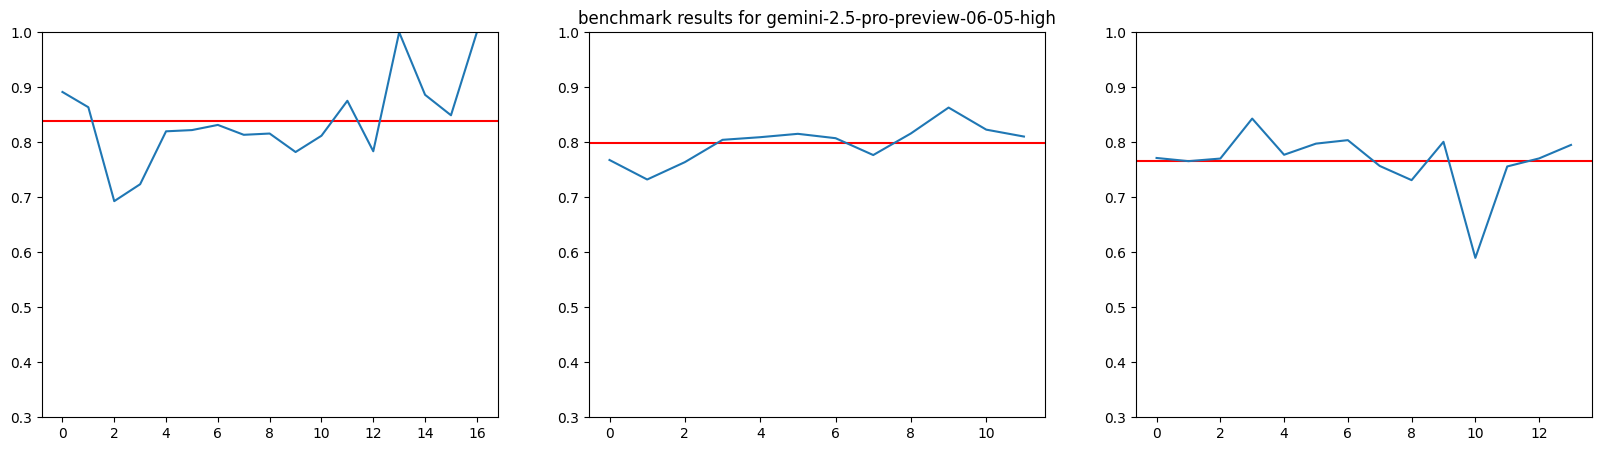

In [182]:
import json
import matplotlib.pyplot as plt
import numpy as np

with open(f'./benchmark_results/first bench/{model}.json') as json_file:
    tests = json.load(json_file)
    
results = {
	"easy":[],
	"intermediate":[],
	"hard":[],
}
for difficulty in tests:
	for test in tests[difficulty]:
		#print(f"{difficulty}:{test} => {tests[difficulty][test]['score']}")
		results[difficulty].append(tests[difficulty][test]['score'])



x = range(len(results["easy"]))
y = results["easy"]
plt.title(f"benchmark results for {model}")
plt.axis('off')
plt.rcParams['figure.figsize'] = [20, 5]

plt.subplot(1, 3, 1)
plt.axhline(y=np.nanmean(y),color=(1,0,0))
plt.ylim((0.3,1))
plt.plot(x,y)
x = range(len(results["intermediate"]))
y = results["intermediate"]

plt.subplot(1, 3, 2)
plt.axhline(y=np.nanmean(y),color=(1,0,0))
plt.ylim((0.3,1))
plt.plot(x,y)

x = range(len(results["hard"]))
y = results["hard"]

plt.subplot(1, 3, 3)
plt.axhline(y=np.nanmean(y),color=(1,0,0))
plt.ylim((0.3,1))
plt.plot(x,y)

plt.show()
		

In [2]:
errorTab = []

In [19]:
import subprocess
import os
import tempfile

def check_latex_compilable(row, engine='pdflatex', timeout=10, iter="common"):
    """
    Compiles LaTeX code and returns (compilable: bool)
    """
    response = row["response"]
    solution = row["solution"]

    with tempfile.TemporaryDirectory() as tmpdir:
        if "\\begin{document}" not in response:
            response = "\\begin{document}\n" + response
        if "\\documentclass{article}" not in response:
            response = "\\documentclass{article}\n" + "\\usepackage{amsmath}\n" + response
        elif "\\usepackage{amsmath}" not in response:
            split = response.split("\\documentclass{article}")
            response = split[0] + "\\documentclass{article}\n\\usepackage{amsmath}\n" + split[1]
        try:
            response = response.split("```latex")[1]
            response = response.split("```")[0]
            
        except Exception as e:
            response = response
        
        tex_file = os.path.join(tmpdir, "document.tex")
        with open(tex_file, "w") as f:
            f.write(response)

        
        try:
            result = subprocess.run(
                [engine, "-interaction=nonstopmode", "-halt-on-error", tex_file],
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                cwd=tmpdir,
                timeout=timeout
            )
            success = int(result.returncode == 0)

            log_file = os.path.join(tmpdir, "document.log")
            log = ""
            if os.path.exists(log_file):
                with open(log_file, "r", encoding="utf-8", errors="ignore") as f:
                    log = f.read()

            if success == 0:
                #print(log)
                if log not in errorTab:
                    errorTab.append(log)
                    print(response)
                    with open(f"./error/{iter}.txt", "w", encoding="utf-8", errors="ignore") as f:
                        f.write(response)
                        f.write("\n\n\n\n\n\n\n")
                        f.write(log)
                        
            return success

        except subprocess.TimeoutExpired:
            #print("Compilation timed out.")
            return 0

        except FileNotFoundError:
            #print(f"Latex engine '{engine}' not found. Make sure it is installed.")
            return 0
        
        except Exception as e:
            #print(f"Something else went wrong with that latex response: {e}")
            return 0



['intermediate_0', 'intermediate_1', 'intermediate_2', 'intermediate_3', 'intermediate_5', 'intermediate_6', 'hard_0', 'hard_1', 'hard_3', 'hard_5', 'hard_6', 'intermediate_4', 'intermediate_7', 'intermediate_8', 'intermediate_9', 'intermediate_10', 'intermediate_11', 'intermediate_12', 'intermediate_13', 'hard_2', 'hard_4', 'hard_7', 'hard_8', 'hard_9', 'hard_10', 'hard_11', 'hard_12', 'hard_13', 'group_1_mean', 'group_2_mean', 'group_1_median', 'group_2_median']


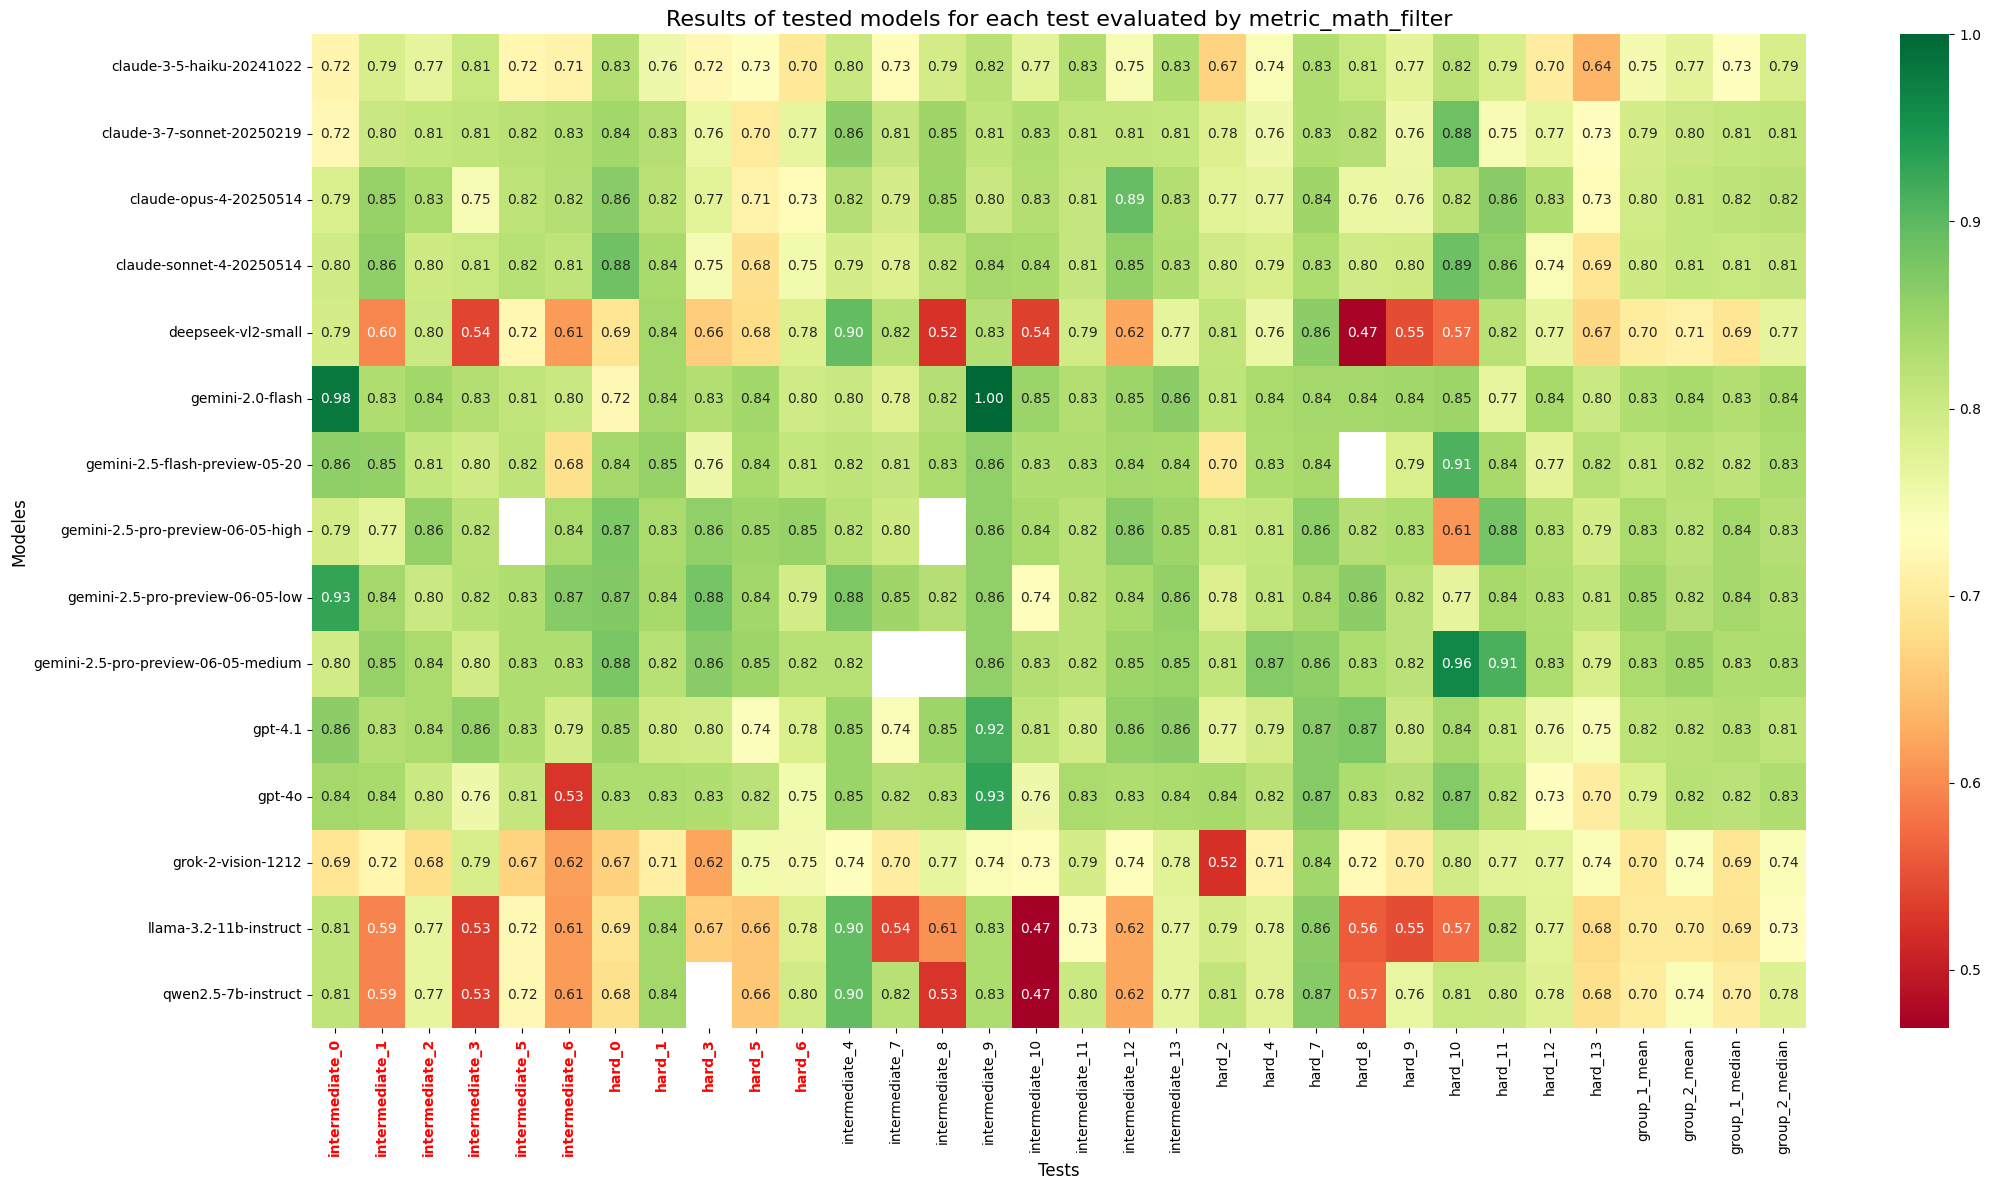

In [23]:
from metrics import results, metric_math_filter, metric_standardized_text

data_dir = "benchmark_results/first bench"
exs_avec_consigne = ['intermediate_0', 'intermediate_1', 'intermediate_2', 'intermediate_3', 'intermediate_5', 'intermediate_6', 'hard_0', 'hard_1', 'hard_3', 'hard_5', 'hard_6']
exs_sans_consigne = ['intermediate_4', 'intermediate_7', 'intermediate_8', 'intermediate_9', 'intermediate_10', 'intermediate_11', 'intermediate_12', 'intermediate_13', 'hard_2', 'hard_4', 'hard_7', 'hard_8', 'hard_9', 'hard_10', 'hard_11', 'hard_12', 'hard_13']


metric = metric_math_filter
metric_name = metric.__name__

res = results(data_dir=data_dir)
res.add_metric(metric_function=metric, mean_med=True)
res.add_separation(exs_avec_consigne, exs_sans_consigne, mean_med=True)
#res.sort_rows(f"{metric_name}_mean")
res.display_metric(f"Results of tested models for each test evaluated by {metric_name}", exs_avec_consigne, exs_sans_consigne)

